<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML23_DZ10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание к лекции «Алгоритмы кластеризации»

**Цель:**

Изучить применение моделей кластеризации

**Описание задания:**

В домашнем задании нужно сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.
Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

#0. Импорт библиотек и вспомогательные функции

In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install hdbscan -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans,DBSCAN, AgglomerativeClustering
import hdbscan
from scipy.stats import mode
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
import cv2
import skimage
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') 


In [ ]:
def transform_color(dff, cluster, method=None):
  """
  Вспомогательная функция для замены цвета писелей
  method='mean' - замена на среднее арифметическое
  method='median' - заменв на медиану
  method='mode' - замена на максимальную моду
  возвращает датафрейм с измененным цветом пикселей
  """
  if method == 'mode':
    med_R = mode(dff.loc[dff['cluster']==cluster, 'R']) # мода R
    med_G = mode(dff.loc[dff['cluster']==cluster, 'G']) # мода G
    med_B = mode(dff.loc[dff['cluster']==cluster, 'B']) # мода B
    
    dff.loc[dff['cluster']==cluster, 'R1'] = med_R[0].max()
    dff.loc[dff['cluster']==cluster, 'G1'] = med_G[0].max()
    dff.loc[dff['cluster']==cluster, 'B1'] = med_B[0].max()
 
  elif method == 'mean':
    med_R = np.mean(dff.loc[dff['cluster']==cluster, 'R']) # среднее значение R
    med_G = np.mean(dff.loc[dff['cluster']==cluster, 'G']) # среднее значение G
    med_B = np.mean(dff.loc[dff['cluster']==cluster, 'B']) # среднее значение B
    
    dff.loc[dff['cluster']==cluster, 'R1'] = int(med_R) # заменяем цвет пикселя на средний
    dff.loc[dff['cluster']==cluster, 'G1'] = int(med_G)
    dff.loc[dff['cluster']==cluster, 'B1'] = int(med_B)
  
  elif method == 'median':
    med_R = np.median(dff.loc[dff['cluster']==cluster, 'R']) # среднее значение R
    med_G = np.median(dff.loc[dff['cluster']==cluster, 'G']) # среднее значение G
    med_B = np.median(dff.loc[dff['cluster']==cluster, 'B']) # среднее значение B
    
    dff.loc[dff['cluster']==cluster, 'R1'] = int(med_R) # заменяем цвет пикселя на средний
    dff.loc[dff['cluster']==cluster, 'G1'] = int(med_G)
    dff.loc[dff['cluster']==cluster, 'B1'] = int(med_B)

  else:
    pass
  return dff


In [ ]:
def draw_picture(image, title, bgr=False):
  """
  Вспомогательная ф-я для отображения картинки
  """
  if bgr: 
    new_image = image
  else:
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
  plt.figure(figsize=(7, 5))
  plt.axis('off')
  plt.imshow(new_image)
  plt.title(title)
  plt.show()
  return new_image

In [ ]:
def get_score(before_, after_, df_results, method, cluster):
  """
  Вспомогательная функция для расчета SSIM и фиксации рехультата
  """
  after_ = cv2.cvtColor(after_, cv2.COLOR_BGR2GRAY)
  # считаем SSIM и сохраняем в датафрейме
  (score, diff) = ssim(before_, after_, full=True)
  
  # Фиксируем результаты в датафрейме
  df_results.loc[len(df_results.index)] = [method, cluster, score]
  return df_results

#1.  Получите данные и загрузите их в рабочую среду

In [ ]:
!wget 'https://www.firestock.ru/wp-content/uploads/2018/03/YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg'

--2023-05-01 12:17:02--  https://www.firestock.ru/wp-content/uploads/2018/03/YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg
Resolving www.firestock.ru (www.firestock.ru)... 185.173.94.96
Connecting to www.firestock.ru (www.firestock.ru)|185.173.94.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110742 (108K) [image/jpeg]
Saving to: ‘YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg’

YArkaya-klumba-Brig 100%[===================>] 108.15K   167KB/s    in 0.6s    

2023-05-01 12:17:03 (167 KB/s) - ‘YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg’ saved [110742/110742]



In [ ]:
base_img = cv2.imread('/content/YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg')
img = cv2.resize(base_img, (350, 233)) # Уменьшаем размер рисунка из-за нехаватки оперативной памяти при расчетах 


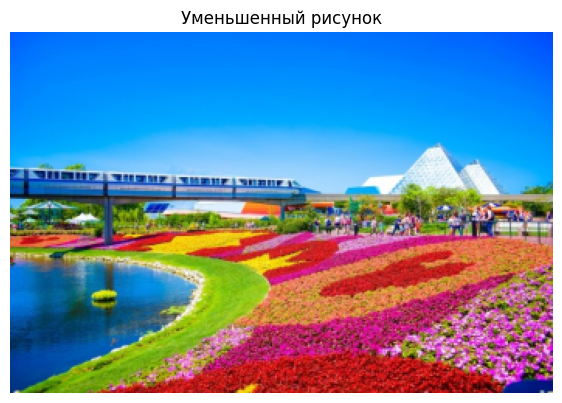

In [ ]:
img = draw_picture(image=img, title="Уменьшенный рисунок", bgr=False)

In [ ]:
print("Свойства изображения")
print("- К-во пикселей: " + str(img.size))
print("- Shape/Dimensions: " + str(img.shape))

Свойства изображения
- К-во пикселей: 244650
- Shape/Dimensions: (233, 350, 3)


In [ ]:
# Переформатируем картинку в 2D array пикселей и (RGB)
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
X = pixel_values

#2. Реализуйте три модели кластеризации:







In [ ]:
df_results = pd.DataFrame(columns=['method', 'n_clusters',  'SSIM'])
num_clusters = [2,5,10,20]
# Для подсчета метрики SSIM нам нужно перевести изображения до и после в оттенки серого
before_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

  a) KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20.

In [ ]:
def Kmeans_clustering(X, num_clusters, before_, sh, df_results):
  for cluster in num_clusters:
    method = 'KMeans'
    # Можно с помощью встроенного метода kmeans sv2
    # _, labels, (centers) = cv2.kmeans(pixel_values, cluster, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Можно с помощью kmeans из sklearn
    kmeans = KMeans(n_clusters=cluster, random_state=42).fit(X)
    centers = kmeans.cluster_centers_ # это центроиды
    labels = kmeans.labels_ # это метки кластеров

    # конвертируем обратно в 8 bit
    centers = np.uint8(centers)

    # разглаживаем массив меток
    labels = labels.flatten()  

    # Преобразуем цвет всех пикселей кластера в цвет центроидов
    segmented_image = centers[labels.flatten()]

    # выполняем reshape назад к оригинальным размерам изображения
    segmented_image = segmented_image.reshape(sh)

    # выводим рисунок
    segmented_image = draw_picture(segmented_image, f'KMeans n_сluster= {cluster}', bgr=True)

    # фиксируеи результаты
    df_results = get_score(before_, segmented_image, df_results, method, cluster)
  return df_results

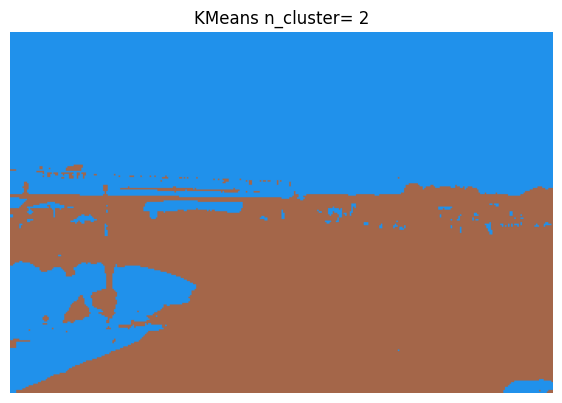

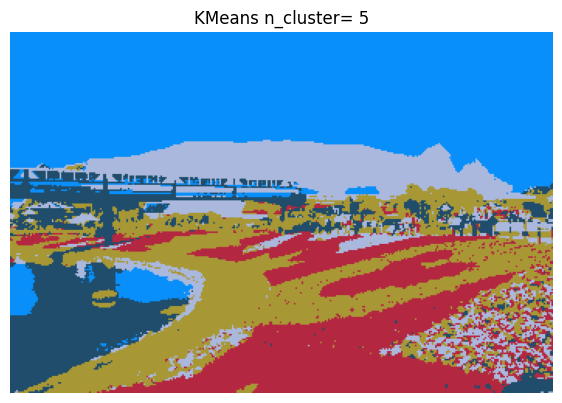

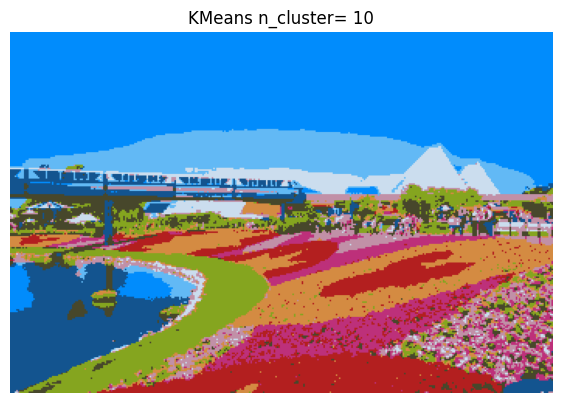

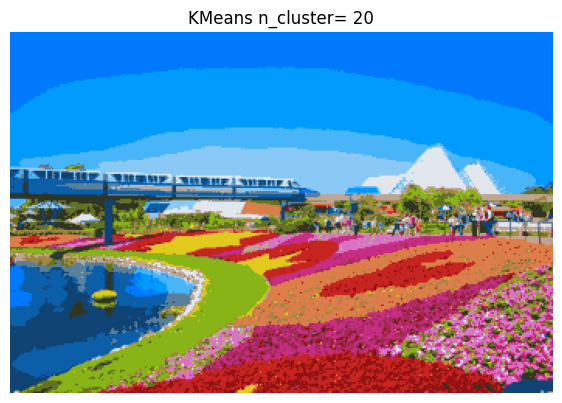

In [ ]:
  df_results = Kmeans_clustering(X, num_clusters, before_, img.shape, df_results)

In [ ]:
df_results

,method,n_clusters,SSIM
0,KMeans,2,0.478211
1,KMeans,5,0.724208
2,KMeans,10,0.788619
3,KMeans,20,0.834077


b) DBSCAN

In [ ]:
def DBSCAN_clustering(X, eps, min_samples, before_, sh, df_results):

  db1 = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
  method = f'DBSCAN eps={eps} mIn_samples={min_samples}'
  labels1 = db1.labels_

  df = pd.DataFrame(X, columns=['R','G', 'B'])
  df1 = pd.DataFrame(labels1, columns=['cluster'])
  dff = pd.concat([df, df1], axis=1)
  weights = dff['cluster'].value_counts().to_dict()
  length = dff.shape[0]
  clusters = set(dff.cluster.unique())
  # print(f'n_clusters= {len(clusters)-1}, % шума = {Counter(labels1)[-1]/labels1.shape[0]*100}')
  dff['weight'] = dff['cluster'].apply(lambda x:weights[x]/length) # определяем вес каждого кластера

  # Выполняем замену цвета пикселей на моду цвета для каждого кластера
  for cluster in clusters:
    dff = transform_color(dff, cluster, method='mode') 
    
  a = np.asarray(list(zip(dff['R1'].to_numpy(), dff['G1'].to_numpy(), dff['B1'].to_numpy())))
  segmented_image1 = np.uint8(a.reshape(sh))

  # выводим рисунок
  segmented_image = draw_picture(segmented_image1, method, bgr=True)

  # фиксируеи результаты
  df_results = get_score(before_, segmented_image, df_results, method, len(clusters)-1) 
  return df_results

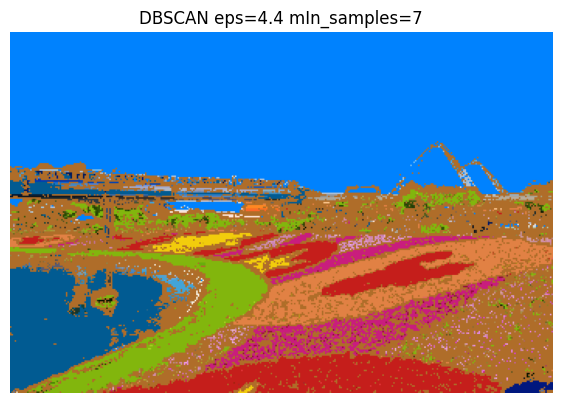

In [ ]:
  eps=4.4 # подбор вручную наилучших значений, при ктороых хватает ОЗУ и качество приемлемое
  min_samples = 7
  df_results = DBSCAN_clustering(X, eps, min_samples, before_, img.shape, df_results)

In [ ]:
df_results

,method,n_clusters,SSIM
0,KMeans,2,0.478211
1,KMeans,5,0.724208
2,KMeans,10,0.788619
3,KMeans,20,0.834077
4,DBSCAN eps=4.4 mIn_samples=7,317,0.597829


## HDBSCAN ( из-за проблем с вычислительными мощностями)

In [ ]:
def HDBSCAN_clustering(X, cluster_selection_epsilon, before_, sh, df_results):

  method = f'HDBSCAN cluster_selection_epsilon={cluster_selection_epsilon}'
  clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon=cluster_selection_epsilon)
  labels = clusterer.fit_predict(X)
  df = pd.DataFrame(X, columns=['R','G', 'B'])
  df1 = pd.DataFrame(labels, columns=['cluster'])
  dff = pd.concat([df, df1], axis=1)
  clusters = set(dff.cluster.unique())

  for cluster in clusters:
    dff = transform_color(dff, cluster, method='mean') 

  # print(f'n_clusters= {np.unique(labels).shape[0]}, % шума = {Counter(labels)[-1]/labels.shape[0]*100}')

  a = np.asarray(list(zip(dff['R1'].to_numpy(), dff['G1'].to_numpy(), dff['B1'].to_numpy())))
  segmented_image1 = np.uint8(a.reshape(sh))

  # выводим рисунок
  segmented_image = draw_picture(segmented_image1, method, bgr=True)

  # фиксируеи результаты
  df_results = get_score(before_, segmented_image, df_results, method, len(clusters)-1) 
  return df_results

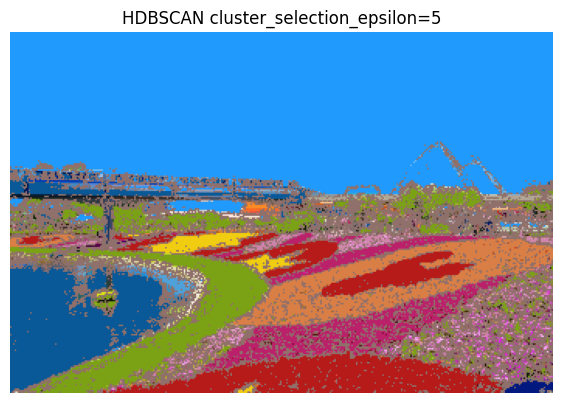

In [ ]:
cluster_selection_epsilon=5
df_results = HDBSCAN_clustering(X, cluster_selection_epsilon, before_, img.shape, df_results)

In [ ]:
df_results

,method,n_clusters,SSIM
0,KMeans,2,0.478211
1,KMeans,5,0.724208
2,KMeans,10,0.788619
3,KMeans,20,0.834077
4,DBSCAN eps=4.4 mIn_samples=7,317,0.597829
5,HDBSCAN cluster_selection_epsilon=5,432,0.650828


c) AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20.

In [ ]:
def agg_clustering(X, num_clusters, before_, sh, df_results):
  connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

  for cluster in num_clusters:
    method = f'AgglomerativeClustering n_clusters={cluster}'
  
    ac = AgglomerativeClustering(
      n_clusters=cluster, linkage="ward", connectivity=connectivity)
    ac.fit(X)
    labels = ac.labels_
    # labels = np.reshape(ac.labels_, X.shape)
    df = pd.DataFrame(X, columns=['R','G', 'B'])
    df1 = pd.DataFrame(labels.flatten(), columns=['cluster'])
    dff = pd.concat([df, df1], axis=1)
    clusters=set(dff.cluster.unique())

    for item in clusters:

      dff = transform_color(dff, item, method='mean') 

    a = np.asarray(list(zip(dff['R1'].to_numpy(), dff['G1'].to_numpy(), dff['B1'].to_numpy())))
    segmented_image1 = np.uint8(a.reshape(sh))
    # выводим рисунок
    segmented_image = draw_picture(segmented_image1, method, bgr=True)

    # фиксируеv результаты
    df_results = get_score(before_, segmented_image, df_results, method, cluster) 
  return df_results

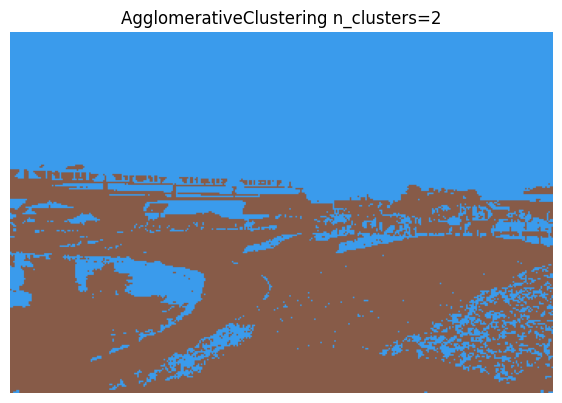

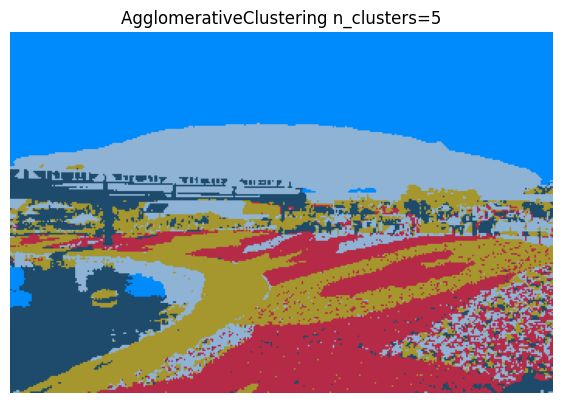

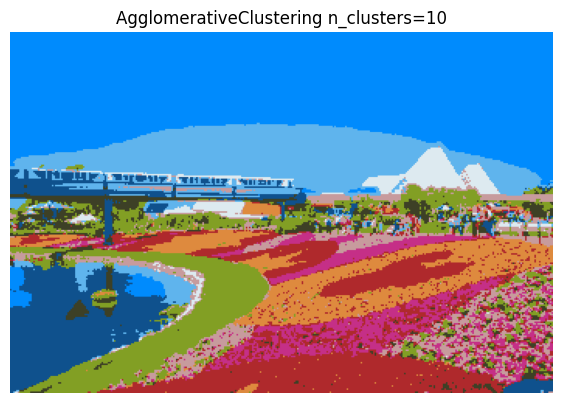

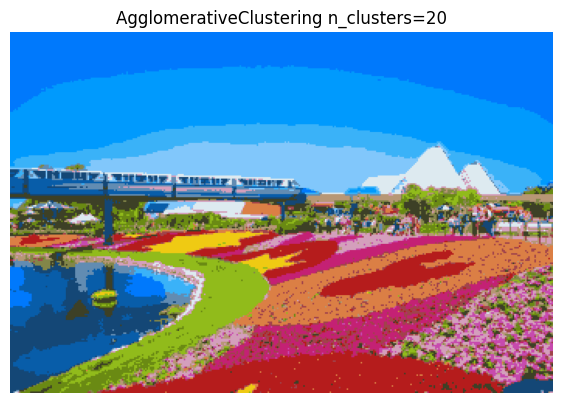

In [ ]:
df_results = agg_clustering(X, num_clusters, before_, img.shape, df_results)

#3. Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM
 https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html.

In [ ]:
df_results.sort_values(by=['SSIM', 'n_clusters'], ascending=[False, True]).style\
         .format('{:.4f}', na_rep='-', subset=['SSIM']) \
         .highlight_null(null_color='lightgrey') \
         .highlight_max(color='yellowgreen', subset=['SSIM']) \
         .highlight_min(color='coral', subset=['SSIM']) 

,method,n_clusters,SSIM
3,KMeans,20,0.8341
9,AgglomerativeClustering n_clusters=20,20,0.8122
2,KMeans,10,0.7886
8,AgglomerativeClustering n_clusters=10,10,0.7696
1,KMeans,5,0.7242
7,AgglomerativeClustering n_clusters=5,5,0.7206
5,HDBSCAN cluster_selection_epsilon=5,432,0.6508
6,AgglomerativeClustering n_clusters=2,2,0.6407
4,DBSCAN eps=4.4 mIn_samples=7,317,0.5978
0,KMeans,2,0.4782


# 4. Сформулируйте выводы по проделанной работе.
a) Какая модель показала лучший результат?

Если опираться  на значение метрики качества SSIM, то наилучшие результаты продемонстрировала модель KMeans ( 0.8122 при n_clusters=20)AgglomerativeClustering n_clusters=20 отстала незначительно ( SSIM = 0.8122). Использование DBSCAN и HSBSCAN не позволило достигнуть хороших показателей SSIM.  Гиперпараметры подбираются неудобно, а затраты памяти таковы, что пришлось выполнять resize исходного рисунка и все пересчитывать. Более удобна в использовании HDBSCAN, но там тоже есть сложности с подбором гиперпараметров.

По удобству использования, скорости работы и затратам памяти KMeans значительно превосходит конкурентов.